# Data Analytics Project - US Macroeconomic Data (1957-2005, Stock & Watson)

Author:      Karolina Świerczek \
Date:        11.06.2021

## Description of the data

Time series data on 7 (mostly) US macroeconomic variables for 1957–2005. \
A quarterly multiple time series from 1957(1) to 2005(1) with 7 variables:
* **unemp**: unemployment rate,
* **cpi**: consumer price index,
* **ffrate**: federal funds interest rate,
* **tbill**: 3-month treasury bill interest rate,
* **tbond**: 1-year treasury bond interest rate,
* **gbpusd**: GBP/USD exchange rate (US dollar in cents per British pound),
* **gdpjp**: GDP (Gross Domestic Product) for Japan.

**Details**: \
The US Consumer Price Index is measured using monthly surveys and is compiled by the Bureau of Labor Statistics (BLS). The unemployment rate is computed from the BLS's Current Population. The quarterly data used here were computed by averaging the monthly values. The interest data are the monthly average of daily rates as reported by the Federal Reserve and the dollar-pound exchange rate data are the monthly average of daily rates; both are for the final month in the quarter. Japanese real GDP data were obtained from the OECD. \
\
**Source**: \
Online complements to Stock and Watson (2007).
[here](https://vincentarelbundock.github.io/Rdatasets/datasets.html?fbclid=IwAR1lJqpEm-yPENAdcUUvSMCW05FXuVwISe2bca4yknulX3DPSTXK9uNDgoc) \
\
**References**: \
Stock, J.H. and Watson, M.W. (2007). Introduction to Econometrics, 2nd ed. Boston: Addison Wesley. 

In [1]:
import scipy.stats as stats
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import matplotlib as mpl
from cmdstanpy import CmdStanModel
import pandas as pd
from scipy.special import expit

### Visual adjustments

In [2]:
light = "#E0FFFF"
light_highlight = "#AFEEEE"
mid = "#40E0D0"
mid_highlight = "#48D1CC"
dark = "#0000FF"
dark_highlight = "#6495ED"
green = "#008000"
light_grey = "#DDDDDD"

plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi'] = 200

### Ribbon plot
This is a visual statistic, showing how quantiles of a sampled variate behave as a function of covariate. 
Example:

In [3]:
import warnings
def is_sorted(a):
    '''Check if numpy 1d-array is sorted
    '''
    if type(a) != np.ndarray:
        raise TypeError('Argument must be a numpy array but is {}'.format(type(a)))
    if len(a.shape) > 1:
        raise ValueError('Array must be 1 dimensional but has shape {}'.format(a.shape))
    return np.all(a[:-1] <= a[1:])

def sort_1d_array_and_2d_array_by_1d_array(x, fx):
    if (type(x) != np.ndarray) or (type(fx) != np.ndarray):
        raise TypeError('At least one of the arguments is not a numpy array; type(x)={}, type(fx)={}'.format(type(x), type(fx)))
    if len(x) != fx.shape[1]:
        raise ValueError('2d array number of columns is not matching the 1d array. Expected {}, got {}'.format(len(x), fx.shape[1]))
    arr2D = np.concatenate([np.expand_dims(x, axis = 0), fx], axis = 0)
    sortedArr = arr2D[:, arr2D[0].argsort()]
    return sortedArr[0, :], sortedArr[1:, :]

def get_quantiles(fx, probs = None):
    if probs is None:
        probs = [10, 20, 30, 40, 50, 60, 70, 80, 90]
    if len(probs) % 2 == 0:
        raise ValueError('Number of quantiles must be even')
    if len(probs) > 11:
        raise ValueError('Too many quantiles (max is 11)')
    if probs[int(len(probs)/2)] != 50:
        raise ValueError('Middle quantile should be 50 but is {}'.format(probs(int(len(probs)/2))))
    return np.percentile(fx, probs, axis=0)

def ribbon_plot(x, fx, ax = None, zorder = 0, probs = None, supress_warning = False):
    '''Plot a ribbon plot for regression and similar.
    Plot consists of quantiles (by 10%) of a variate (fx) as a function of covariate (x).
    x has shape (n, )
    fx has shape (N, n)
    '''
    if ax is None:
        ax = plt.gca()
    if not is_sorted(x):
        x, fx = sort_1d_array_and_2d_array_by_1d_array(x, fx)
    if (len(set(x)) != len(x)) and (not supress_warning):
        warnings.warn("x variable has repeated values, which can influence the plot")    
    perc_interv = get_quantiles(fx, probs)
    nq = perc_interv.shape[0]
    colortab = [light, light_highlight, mid, mid_highlight, dark, dark_highlight]

    for i in range(int(nq/2)):
        ax.fill_between(x,
                        perc_interv[i, :],
                        perc_interv[-(i+1), :],
                        color = colortab[i],
                        zorder = zorder)
    ax.plot(x, perc_interv[int(nq/2), :], color = colortab[int(nq/2)], zorder = zorder)
    return ax

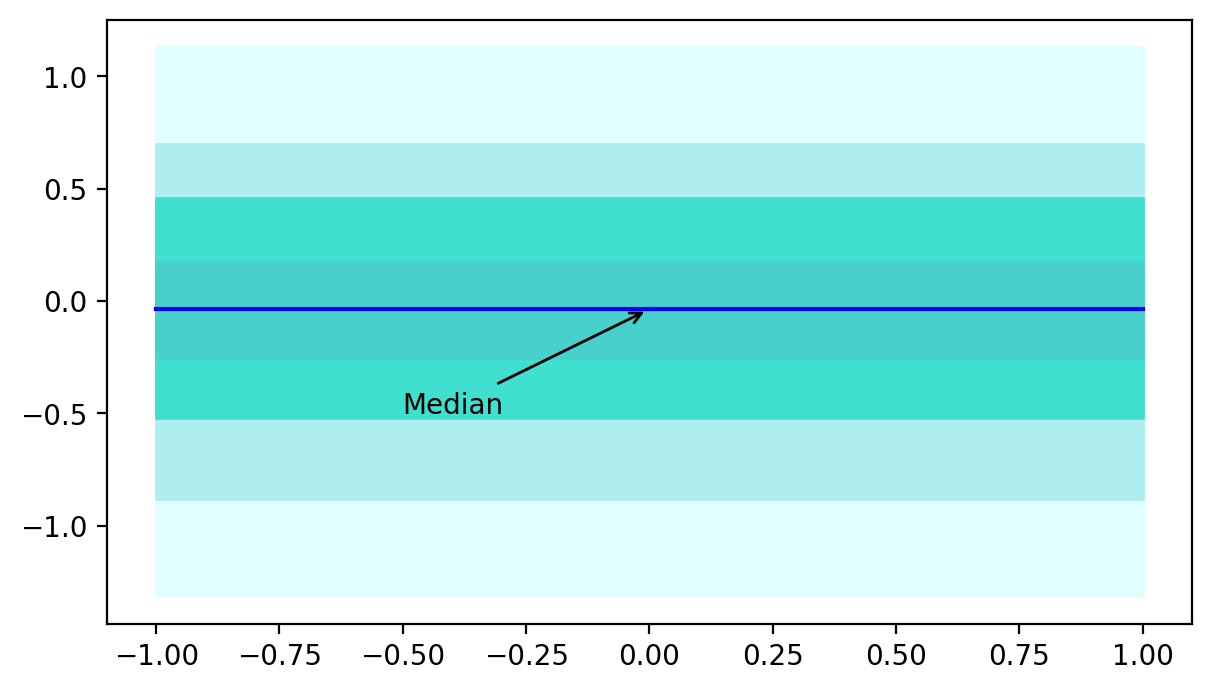

In [4]:
fig, axes = plt.subplots(1, 1, figsize = (7, 4))
covariate = np.linspace(-1, 1)
np.random.seed(4052576)
variate = np.repeat(np.random.normal(size = 1000)[:, None], 50, axis = 1)
axes = ribbon_plot(covariate, variate)
axes.annotate('Median', xy = (0, np.median(variate[:, 0])), xytext = (-0.5, -0.5), arrowprops = {'arrowstyle':'->'})
plt.show()

### Loading the data

In [5]:
data = pd.read_csv('USMacroSW.csv', sep = ',', header = 0)
data.head()

,Unnamed: 0,unemp,cpi,ffrate,tbill,tbond,gbpusd,gdpjp
0,1,3.933333,27.776667,2.96,3.08,3.42,279.304688,10149.0
1,2,4.100000,28.013334,3.00,3.29,3.65,279.023712,10904.0
2,3,4.233333,28.263334,3.47,3.53,4.07,278.508789,11231.0
3,4,4.933333,28.400000,2.98,3.04,3.18,280.579590,11075.0
4,5,6.300000,28.736666,1.20,1.30,1.84,281.539795,10973.0


### Basic analysis of the data

In [6]:
print(data.columns)

Index(['Unnamed: 0', 'unemp', 'cpi', 'ffrate', 'tbill', 'tbond', 'gbpusd',
       'gdpjp'],
      dtype='object')


In [7]:
data.rename(columns = {"Unnamed: 0": "quarter"}, inplace = True)
data.head()

,quarter,unemp,cpi,ffrate,tbill,tbond,gbpusd,gdpjp
0,1,3.933333,27.776667,2.96,3.08,3.42,279.304688,10149.0
1,2,4.100000,28.013334,3.00,3.29,3.65,279.023712,10904.0
2,3,4.233333,28.263334,3.47,3.53,4.07,278.508789,11231.0
3,4,4.933333,28.400000,2.98,3.04,3.18,280.579590,11075.0
4,5,6.300000,28.736666,1.20,1.30,1.84,281.539795,10973.0


In [8]:
date = [None]*len(data)
date[0] = 1957
date[1] = 1957
date[2] = 1957
date[3] = 1957
for i in range(4, len(data)):
    if i % 4 == 0:
        date[i] = date[i-1]+1
    else:
        date[i] = date[i-1]
print(date)

[1957, 1957, 1957, 1957, 1958, 1958, 1958, 1958, 1959, 1959, 1959, 1959, 1960, 1960, 1960, 1960, 1961, 1961, 1961, 1961, 1962, 1962, 1962, 1962, 1963, 1963, 1963, 1963, 1964, 1964, 1964, 1964, 1965, 1965, 1965, 1965, 1966, 1966, 1966, 1966, 1967, 1967, 1967, 1967, 1968, 1968, 1968, 1968, 1969, 1969, 1969, 1969, 1970, 1970, 1970, 1970, 1971, 1971, 1971, 1971, 1972, 1972, 1972, 1972, 1973, 1973, 1973, 1973, 1974, 1974, 1974, 1974, 1975, 1975, 1975, 1975, 1976, 1976, 1976, 1976, 1977, 1977, 1977, 1977, 1978, 1978, 1978, 1978, 1979, 1979, 1979, 1979, 1980, 1980, 1980, 1980, 1981, 1981, 1981, 1981, 1982, 1982, 1982, 1982, 1983, 1983, 1983, 1983, 1984, 1984, 1984, 1984, 1985, 1985, 1985, 1985, 1986, 1986, 1986, 1986, 1987, 1987, 1987, 1987, 1988, 1988, 1988, 1988, 1989, 1989, 1989, 1989, 1990, 1990, 1990, 1990, 1991, 1991, 1991, 1991, 1992, 1992, 1992, 1992, 1993, 1993, 1993, 1993, 1994, 1994, 1994, 1994, 1995, 1995, 1995, 1995, 1996, 1996, 1996, 1996, 1997, 1997, 1997, 1997, 1998, 1998, 199

In [9]:
data['date'] = date
data.head()

,quarter,unemp,cpi,ffrate,tbill,tbond,gbpusd,gdpjp,date
0,1,3.933333,27.776667,2.96,3.08,3.42,279.304688,10149.0,1957
1,2,4.100000,28.013334,3.00,3.29,3.65,279.023712,10904.0,1957
2,3,4.233333,28.263334,3.47,3.53,4.07,278.508789,11231.0,1957
3,4,4.933333,28.400000,2.98,3.04,3.18,280.579590,11075.0,1957
4,5,6.300000,28.736666,1.20,1.30,1.84,281.539795,10973.0,1958


In [10]:
data = data[['quarter', 'date', 'unemp', 'cpi', 'ffrate', 'tbill', 'tbond', 'gbpusd', 'gdpjp']]
data.head()

,quarter,date,unemp,cpi,ffrate,tbill,tbond,gbpusd,gdpjp
0,1,1957,3.933333,27.776667,2.96,3.08,3.42,279.304688,10149.0
1,2,1957,4.100000,28.013334,3.00,3.29,3.65,279.023712,10904.0
2,3,1957,4.233333,28.263334,3.47,3.53,4.07,278.508789,11231.0
3,4,1957,4.933333,28.400000,2.98,3.04,3.18,280.579590,11075.0
4,5,1958,6.300000,28.736666,1.20,1.30,1.84,281.539795,10973.0


In [11]:
print(data.unemp.describe())

count    193.000000
mean       5.891019
std        1.438074
min        3.400000
25%        5.000000
50%        5.700000
75%        6.833333
max       10.666667
Name: unemp, dtype: float64


In [12]:
print(data.tbond.describe())

count    193.000000
mean       6.040207
std        2.954469
min        1.010000
25%        3.910000
50%        5.620000
75%        7.550000
max       16.520000
Name: tbond, dtype: float64


In [13]:
print(data.ffrate.describe())

count    193.000000
mean       5.953161
std        3.376566
min        0.930000
25%        3.480000
50%        5.400000
75%        7.760000
max       19.100000
Name: ffrate, dtype: float64


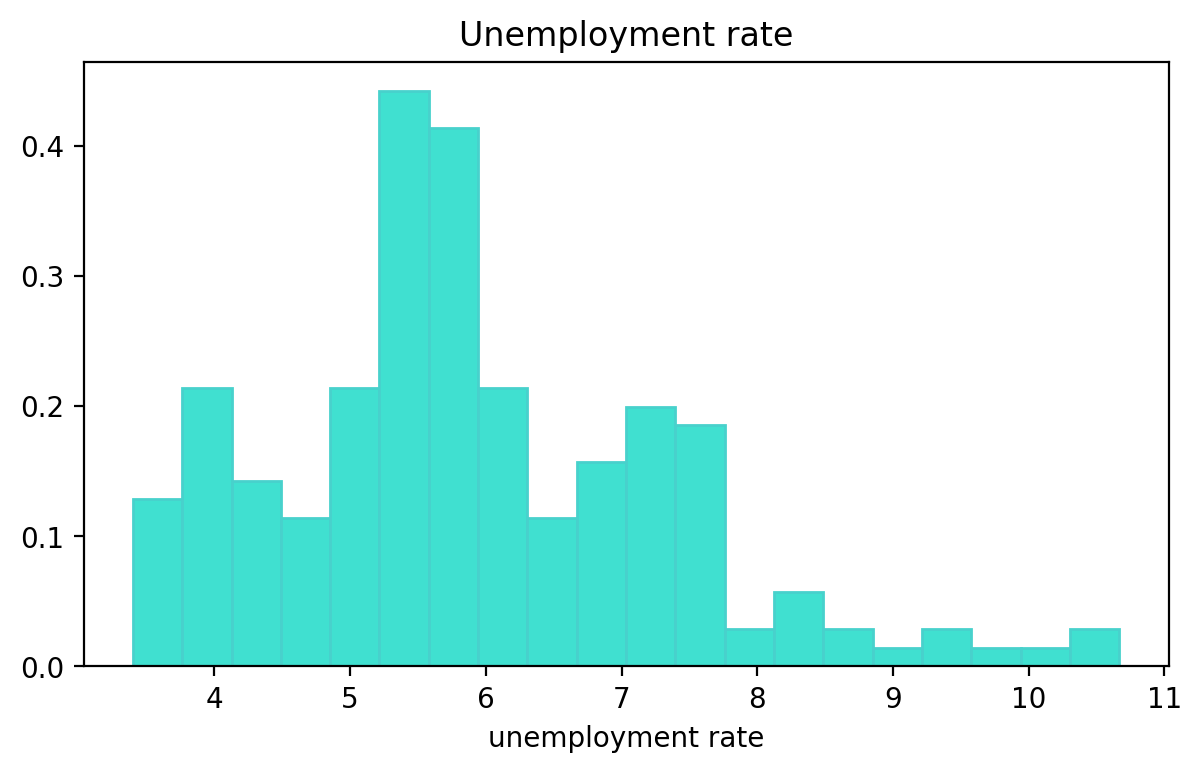

In [14]:
unemp = data.unemp.to_numpy()
fig, ax = plt.subplots(1, 1, figsize = (7, 4))
ax.hist(unemp, bins = 20, color = mid, edgecolor = mid_highlight, density = True)
plt.xlabel('unemployment rate')
plt.title(str("Unemployment rate"))
plt.show(ax)

## Normal model with no predictors

I will try to fit $\mathrm{Normal}(\mu,\sigma)$ distribution to unemployment rate data.

## Prior predictive checks

Basic research provided me with the information that mean of the unemployment rate is approximately equal to 5 and the standard deviation of the unemployment rate is approximately equal to 1. Taking that into account I create the following model:

In [15]:
with open('macro_ppc.stan', 'r') as file:
    print(file.read())

generated quantities {
  real mu = normal_rng(5, 1);
  real sigma = exponential_rng(1);
  real unemp_prior = normal_rng(mu, sigma);
}


In [16]:
macro_ppc_model = CmdStanModel(stan_file = 'macro_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: C:/Users/Karolina/DA_2021/8MINIP~1/macro_ppc.exe


In [17]:
R = 1000
sim = macro_ppc_model.sample(iter_sampling = R, 
                             iter_warmup = 0,
                             chains = 1,
                             fixed_param = True,
                             seed = 11062021)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [18]:
mu_sim = sim.stan_variable('mu')
sigma_sim = sim.stan_variable('sigma')
unemp_prior_sim = sim.stan_variable('unemp_prior')

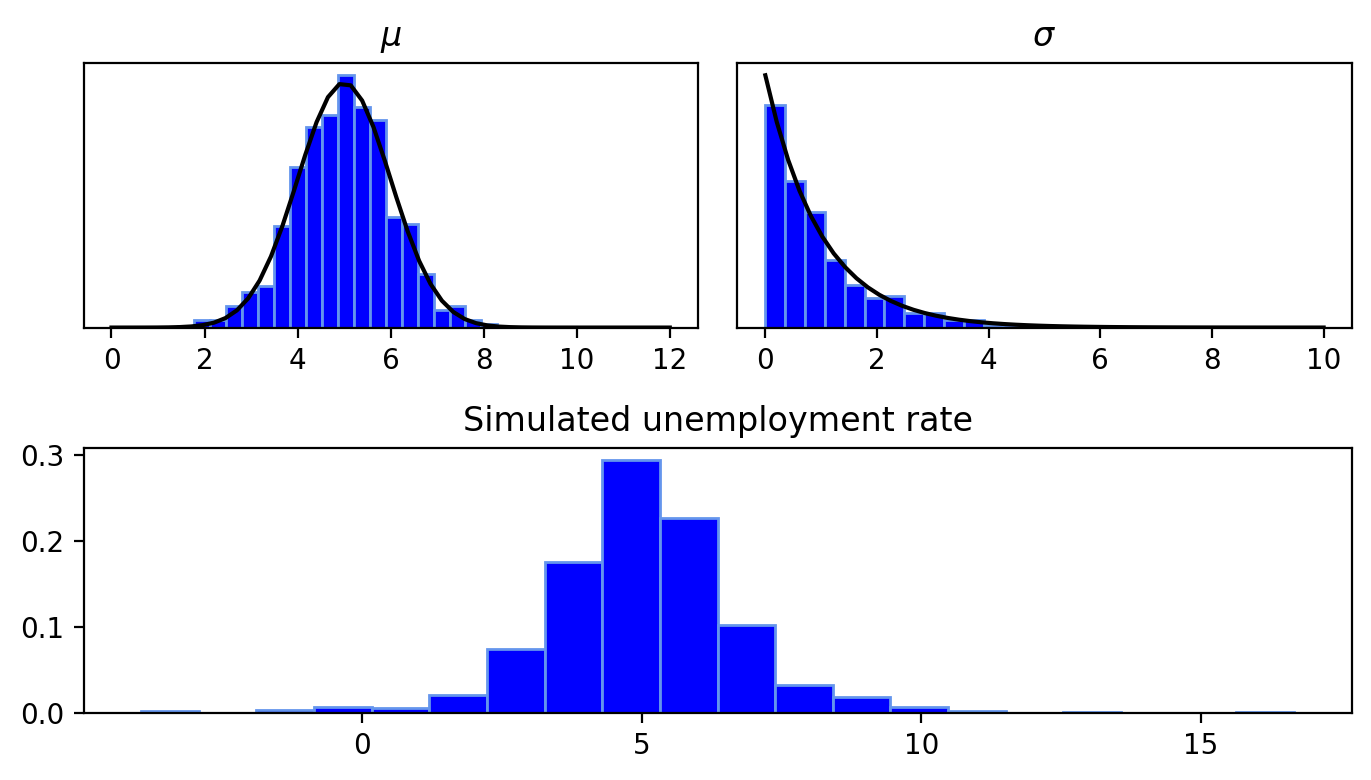

In [19]:
fig = plt.figure(figsize = (7, 4))

gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[1, :])
ax1.hist(unemp_prior_sim, bins = 20, color = dark, edgecolor = dark_highlight, density = True)
ax1.set_title('Simulated unemployment rate')

ax2 = fig.add_subplot(gs[0, 0])
ax2.hist(mu_sim, bins = 20, color = dark, edgecolor = dark_highlight, density = True)
x = np.linspace(0, 12)
y = stats.norm.pdf(x, loc = 5, scale = 1)
ax2.plot(x, y, 'black')
ax2.set_title('$\mu$')
ax2.set_yticks([])

ax3 = fig.add_subplot(gs[0, 1])
ax3.hist(sigma_sim, bins = 20, color = dark, edgecolor = dark_highlight, density = True)
x = np.linspace(0, 10)
y = stats.expon.pdf(x, scale = 1)
ax3.plot(x, y, color = 'black')
ax3.set_title('$\sigma$')
ax3.set_yticks([])

fig.tight_layout()
plt.show()

## Posterior and inference

In [20]:
with open('macro_fit.stan', 'r') as file:
    print(file.read())

data {
  int N;
  real unemp_data[N];
}

parameters {
  real mu;
  real<lower=0> sigma;
}

model {
  mu ~ normal(5, 1);
  sigma ~ exponential(1);
  unemp_data ~ normal(mu, sigma);
}

generated quantities {
  vector[N] log_lik;
  for (i in 1:N) {
    log_lik[i] = normal_lpdf(unemp_data[i] | mu, sigma);
  }
  real unemp_posterior = normal_rng(mu, sigma);
}


In [21]:
macro_fit_model = CmdStanModel(stan_file = 'macro_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: C:/Users/Karolina/DA_2021/8MINIP~1/macro_fit.exe


In [22]:
macro_fit = macro_fit_model.sample(data = dict(N = len(data),
                                               unemp_data = data.unemp.values),
                                   seed = 11062021)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1


In [23]:
az.summary(macro_fit, var_names = ['mu', 'sigma'], round_to = 2, kind = 'stats')

,mean,sd,hdi_3%,hdi_97%
mu,5.88,0.11,5.69,6.08
sigma,1.44,0.07,1.31,1.58


In [24]:
mu_fit = macro_fit.stan_variable('mu')
sigma_fit = macro_fit.stan_variable('sigma')
unemp_posterior_pred = macro_fit.stan_variable('unemp_posterior')

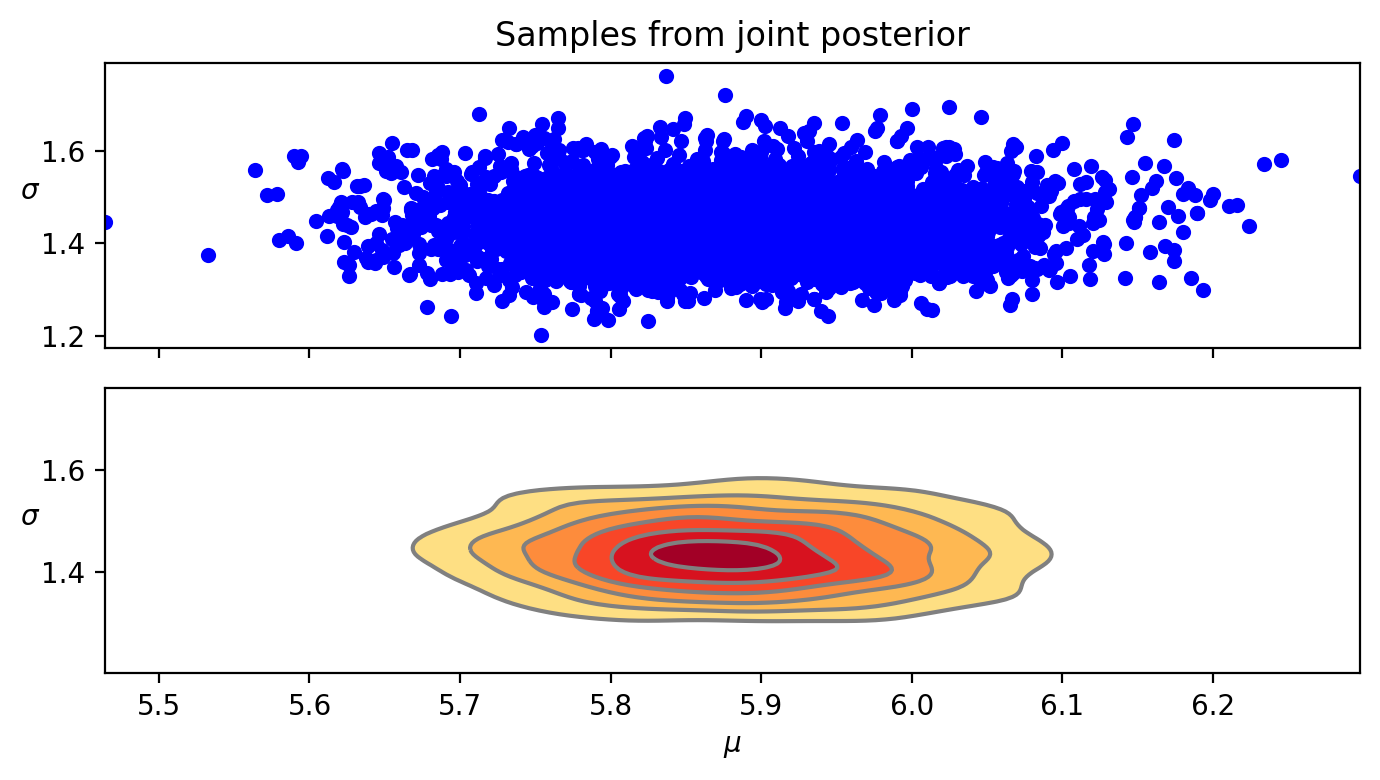

In [25]:
fig, axes = plt.subplots(2, 1, figsize = (7, 4), sharex = True)
ax1 = axes[0]
ax1.scatter(mu_fit, sigma_fit, 20, color = dark)
ax1.set_ylabel(r'$\sigma$', rotation = 0)
ax1.set_title('Samples from joint posterior')

ax2 = axes[1]
az.plot_kde(mu_fit, sigma_fit, ax = ax2, contourf_kwargs = {'cmap': 'YlOrRd'})
fig.tight_layout()
ax2.set_xlabel(r'$\mu$')
ax2.set_ylabel(r'$\sigma$', rotation = 0)
fig.tight_layout()

plt.show()

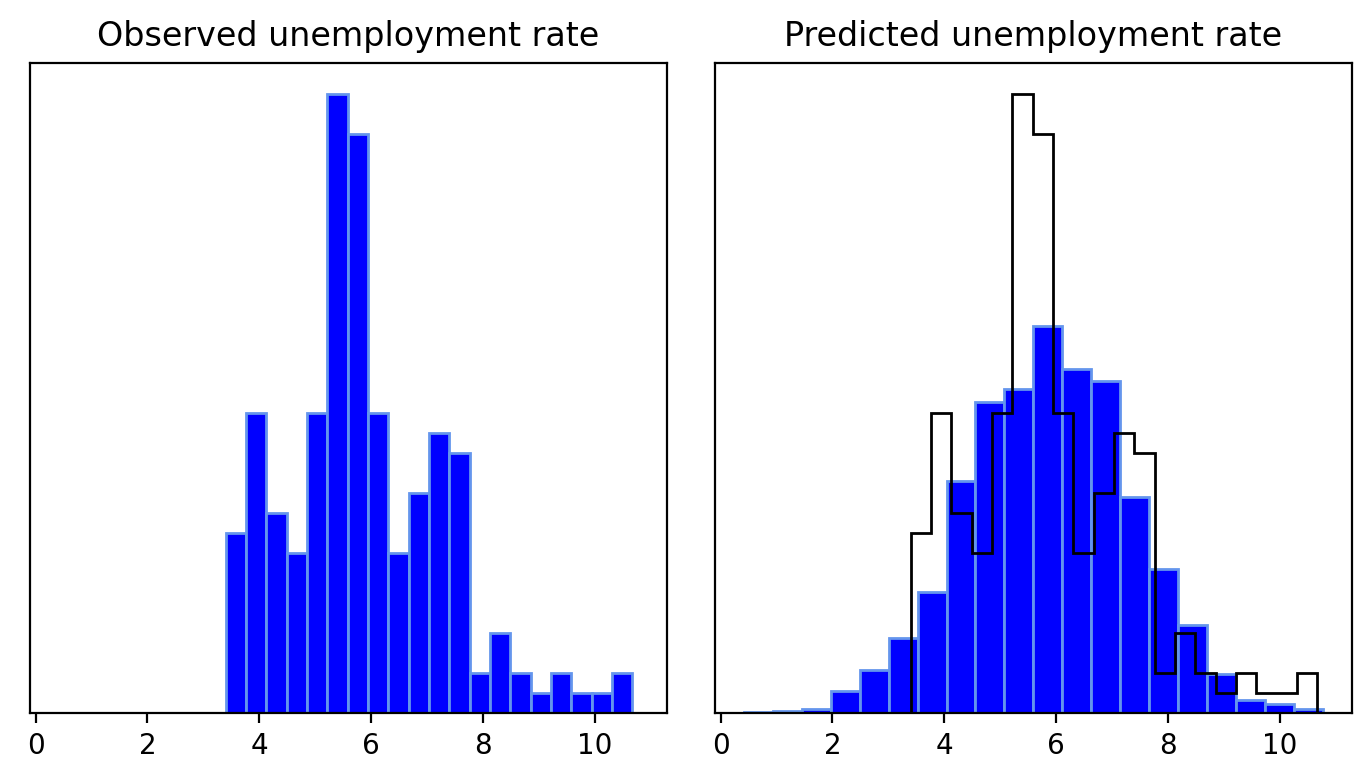

In [26]:
fig, axes = plt.subplots(1, 2, figsize = (7, 4), sharex = True, sharey = True)
ax = axes[0]
ax.hist(data.unemp, bins = 20, color = dark, edgecolor = dark_highlight, density = True)
ax.set_title('Observed unemployment rate')
ax.set_yticks(())
ax2 = axes[1]
ax2.hist(unemp_posterior_pred, bins = 20, color = dark, edgecolor = dark_highlight, density = True)
ax2.hist(data.unemp, bins = 20, histtype = 'step', color = 'black', density = True)

ax2.set_title('Predicted unemployment rate')
ax2.set_yticks(())
fig.tight_layout()

plt.show()

## Improving model - adding a predictor

Previous results have satisfyingly reproduced the actual data, but I would like the model to be even more accurate. In this section, I will introduce a predictor in the following form: tbond - 1-year treasury bond interest rate.

### Centering of a variable

In [27]:
data['c_tbond'] = (data.tbond-data.tbond.mean())/data.tbond.mean()
data.head()

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


,quarter,date,unemp,cpi,ffrate,tbill,tbond,gbpusd,gdpjp,c_tbond
0,1,1957,3.933333,27.776667,2.96,3.08,3.42,279.304688,10149.0,-0.433794
1,2,1957,4.100000,28.013334,3.00,3.29,3.65,279.023712,10904.0,-0.395716
2,3,1957,4.233333,28.263334,3.47,3.53,4.07,278.508789,11231.0,-0.326182
3,4,1957,4.933333,28.400000,2.98,3.04,3.18,280.579590,11075.0,-0.473528
4,5,1958,6.300000,28.736666,1.20,1.30,1.84,281.539795,10973.0,-0.695375


### Prior predictive checks

In [28]:
with open('macro_2_ppc.stan', 'r') as file:
    print(file.read())

data {
  int N;
  real tbond[N];
}

generated quantities {
  real alpha = normal_rng(5, 1);
  real beta = lognormal_rng(0, 1);
  real sigma = exponential_rng(1);
  real unemp[N];
  for (i in 1:N) {
    unemp[N] = normal_rng(tbond[N]*beta + alpha, sigma);
  }
}



In [29]:
macro_2_ppc_model = CmdStanModel(stan_file = 'macro_2_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: C:/Users/Karolina/DA_2021/8MINIP~1/macro_2_ppc.exe


In [30]:
R = 1000
data_sim = dict(N = len(data), tbond = data.c_tbond.values)

sim = macro_2_ppc_model.sample(data = data_sim,
                               iter_sampling = R,
                               iter_warmup = 0,
                               chains = 1,
                               fixed_param = True,
                               seed = 11062021)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [31]:
alpha_sim = sim.stan_variable('alpha')
beta_sim = sim.stan_variable('beta')

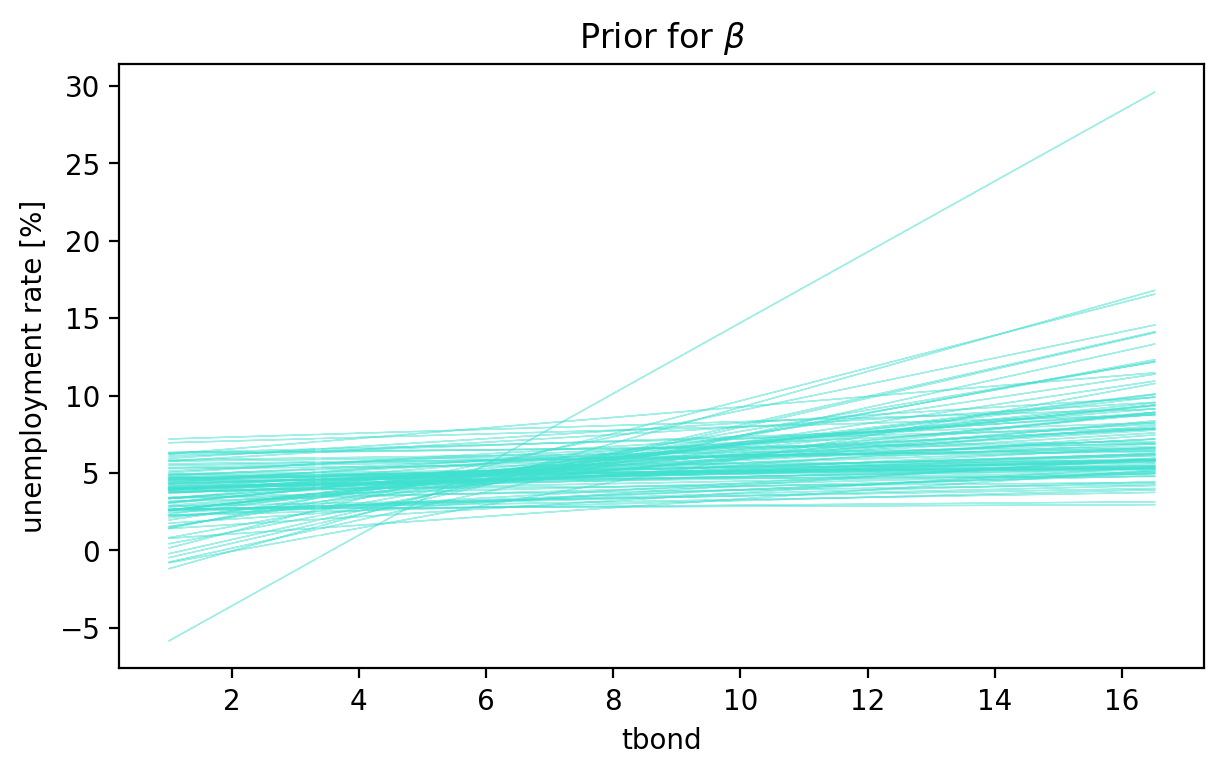

In [32]:
fig, axes = plt.subplots(1, 1, figsize = (7, 4))
for i in range(100):
    axes.plot(data.tbond, alpha_sim[i] + beta_sim[i]*data.c_tbond, color = mid, alpha = 0.5, linewidth = 0.5)
axes.set_xlabel('tbond')
axes.set_ylabel('unemployment rate [%]')
axes.set_title(r'Prior for $\beta$')
plt.show()

### Posterior inference

In [33]:
with open('macro_2_fit.stan', 'r') as file:
    print(file.read())

data {
  int N;
  vector[N] tbond;
  real unemp_data[N];
}

parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}

transformed parameters {
  vector[N] mu = tbond*beta + alpha;
}

model {
  alpha ~ normal(5, 1);
  beta ~ lognormal(0, 1);
  sigma ~ exponential(1);
  unemp_data ~ normal(mu, sigma);
}

generated quantities {
  vector[N] log_lik;
  real unemp_posterior[N];
  for (i in 1:N) {
    log_lik[i] = normal_lpdf(unemp_data[i] | mu[i], sigma);
    unemp_posterior[i] = normal_rng(mu[i], sigma);
  }
}



In [34]:
macro_2_fit_model = CmdStanModel(stan_file = 'macro_2_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: C:/Users/Karolina/DA_2021/8MINIP~1/macro_2_fit.exe


In [35]:
data_fit = dict(N = len(data),
                tbond = data.tbond.values,
                unemp_data = data.unemp.values)

macro_2_fit = macro_2_fit_model.sample(data = data_fit,
                                       seed = 11062021)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3


In [36]:
alpha_fit = macro_2_fit.stan_variable('alpha')
beta_fit = macro_2_fit.stan_variable('beta')
mu_fit = macro_2_fit.stan_variable('mu')
unemp_posterior_pred_tbond = macro_2_fit.stan_variable('unemp_posterior')

In [37]:
az.summary(macro_2_fit, var_names = ['alpha', 'beta', 'sigma'], round_to = 2, kind = 'stats')

,mean,sd,hdi_3%,hdi_97%
alpha,4.85,0.21,4.47,5.28
beta,0.17,0.03,0.11,0.23
sigma,1.36,0.07,1.23,1.50


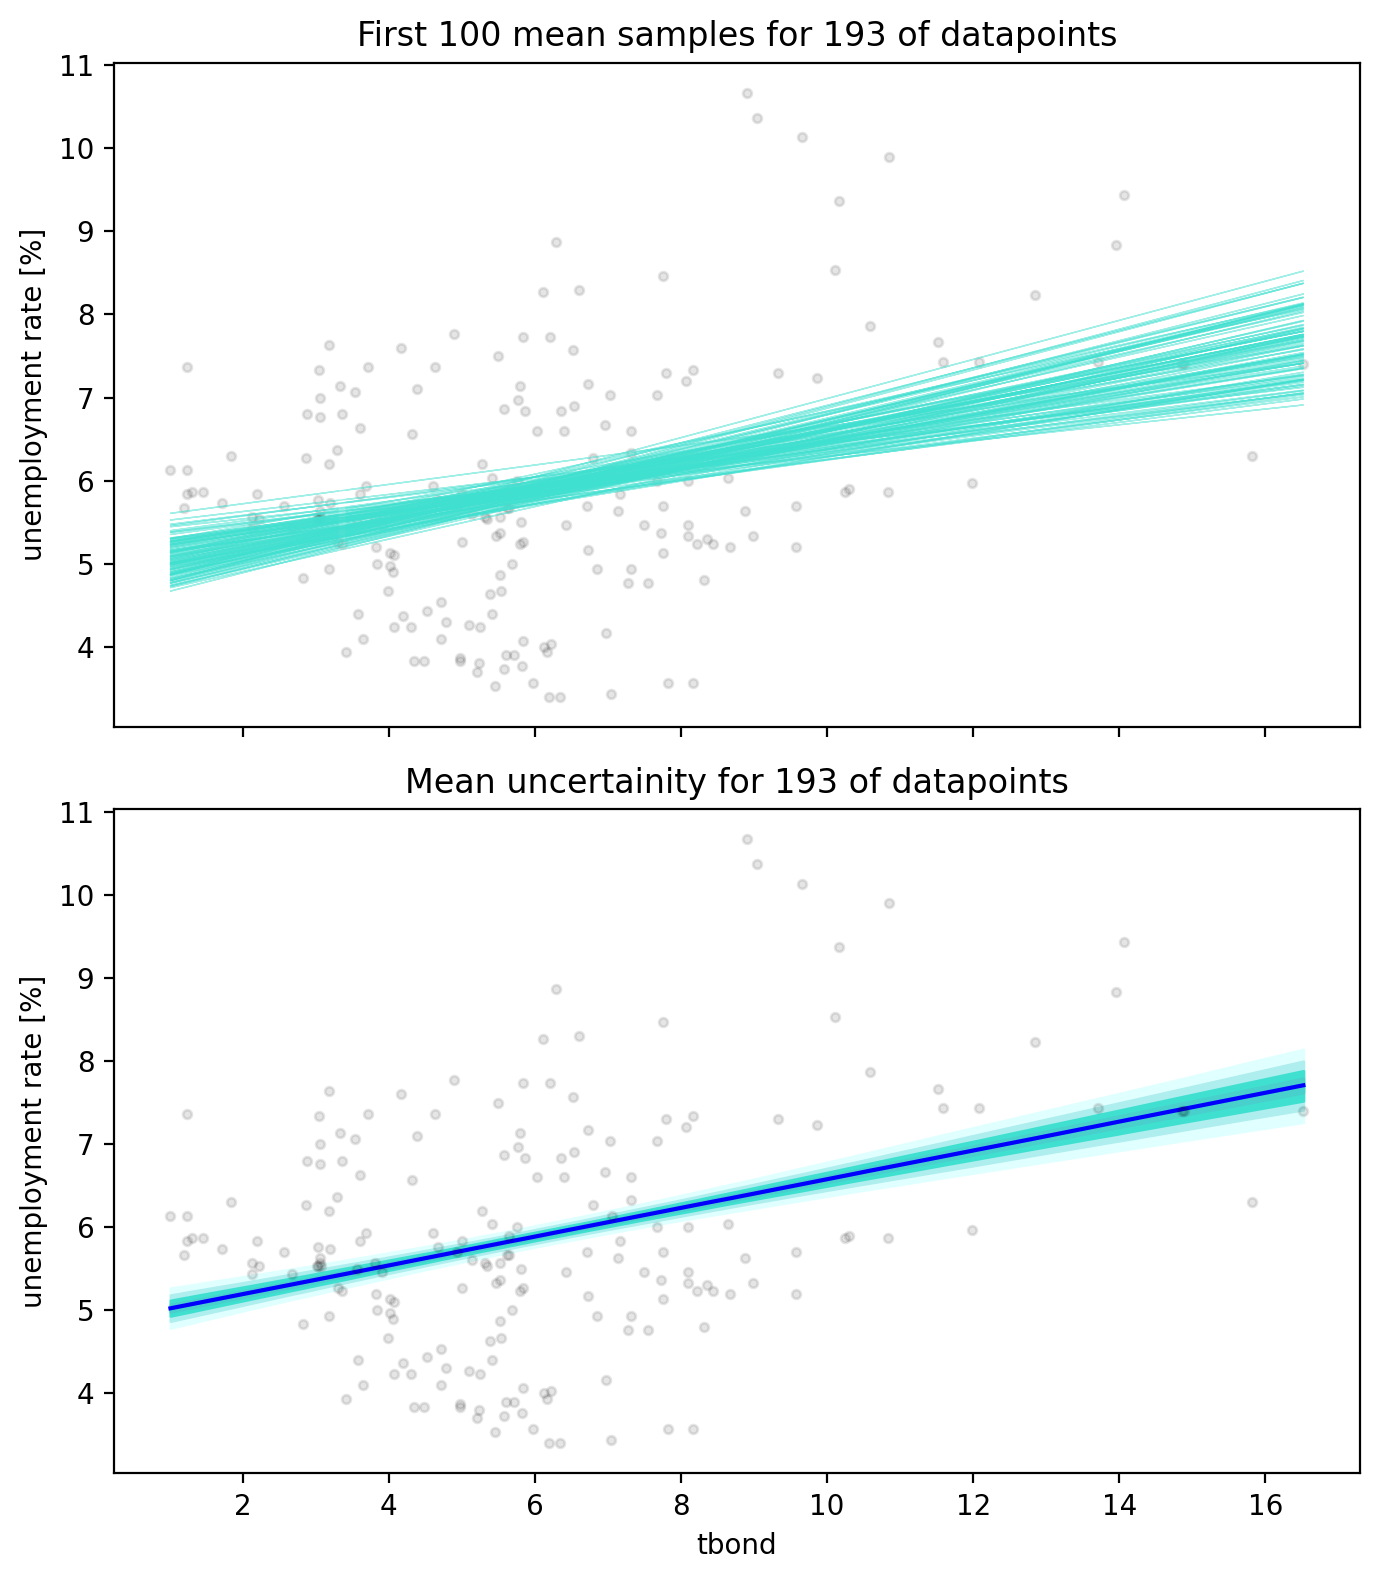

In [38]:
fig, axes = plt.subplots(2, 1, figsize = (7, 8), sharey = True, sharex = True)
ax0 = axes[0]
rng = 100
for i in range(rng):
    ax0.plot(data.tbond,
             alpha_fit[i] + beta_fit[i]*data.tbond,
             color = mid, alpha = 0.5, linewidth = 0.5)
ax0.scatter(data.tbond, data.unemp, color = 'black', alpha = 0.1, s = 10)
ax0.set_ylabel('unemployment rate [%]')
ax0.set_title('First {0} mean samples for {1} of datapoints'.format(rng, len(data)))

ax1 = axes[1]
ax1 = ribbon_plot(data.tbond.values, mu_fit, ax1, supress_warning = True)
ax1.scatter(data.tbond, data.unemp, color = 'black', alpha = 0.1, s = 10)
ax1.set_xlabel('tbond')
ax1.set_ylabel('unemployment rate [%]')

ax1.set_title('Mean uncertainity for {} of datapoints'.format(len(data)))
fig.tight_layout()
plt.show()

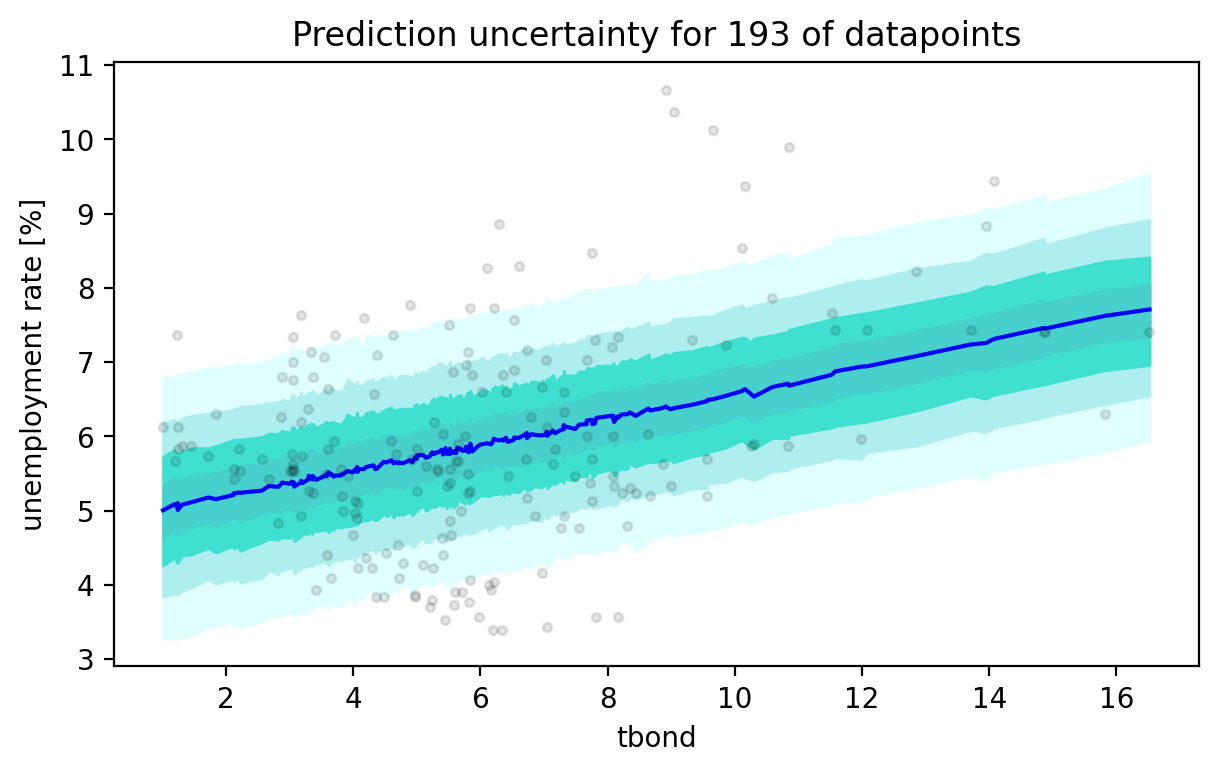

In [39]:
fig, axes = plt.subplots(1, 1, figsize = (7, 4))
axes = ribbon_plot(data.tbond.values, unemp_posterior_pred_tbond, axes, supress_warning = True)
axes.scatter(data.tbond, data.unemp, color = 'black', alpha = 0.1, s = 10)
axes.set_xlabel('tbond')
axes.set_ylabel('unemployment rate [%]')
axes.set_title('Prediction uncertainty for {} of datapoints'.format(len(data)))
plt.show()

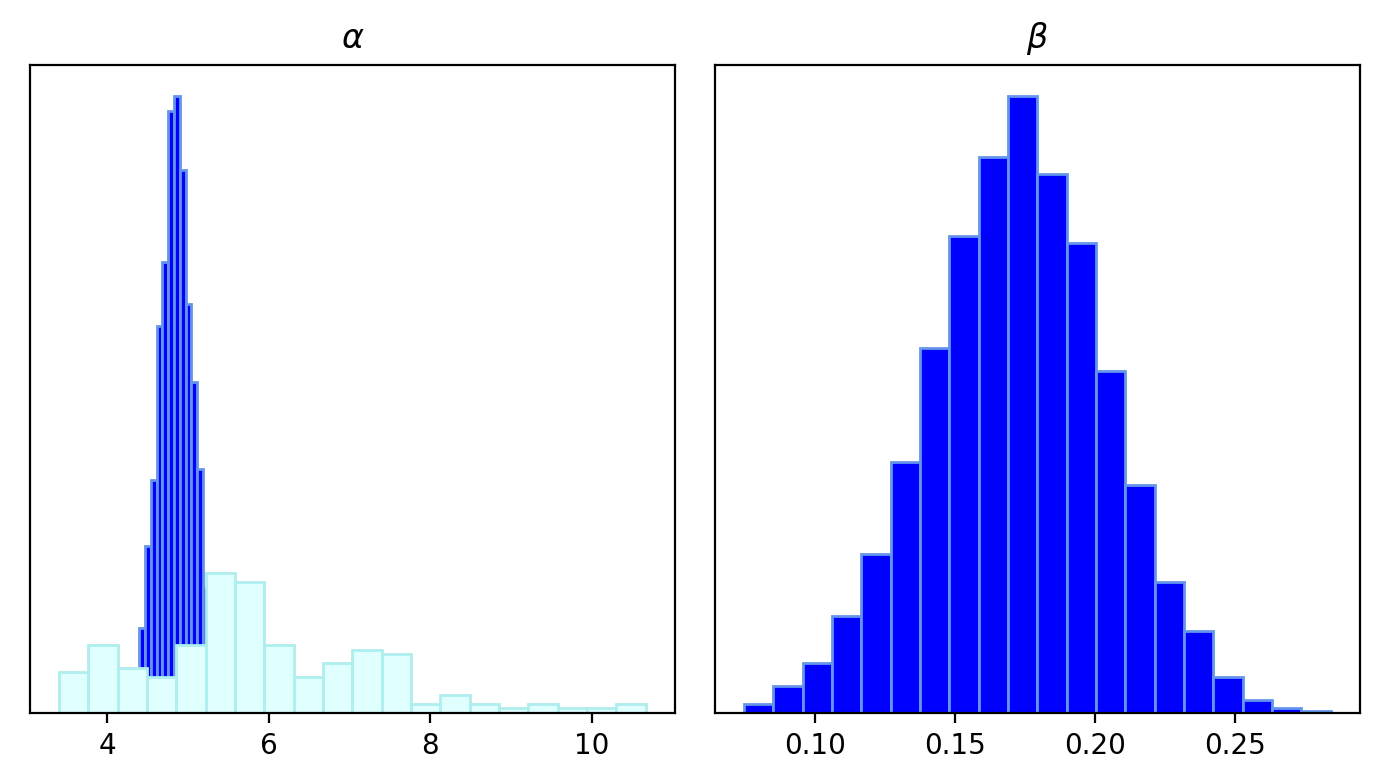

In [40]:
fig, axes = plt.subplots(1, 2, figsize = (7, 4))
ax = axes[0]
ax.hist(alpha_fit, bins = 20, color = dark, edgecolor = dark_highlight, density = True)
ax.hist(data.unemp, bins = 20, color = light, edgecolor = light_highlight, density = True)
ax.set_title(r'$\alpha$')
ax.set_yticks(())

ax2 = axes[1]
ax2.hist(beta_fit, bins = 20, color = dark, edgecolor = dark_highlight, density = True)
ax2.set_title(r'$\beta$')
ax2.set_yticks(())

fig.tight_layout()
plt.show()

### Posterior predictive check

In [41]:
fit_id = az.from_cmdstanpy(posterior = macro_2_fit,
                                       log_likelihood = 'log_lik',
                                       posterior_predictive = 'unemp_posterior',
                                       observed_data = {'unemp_data': data['unemp']} )

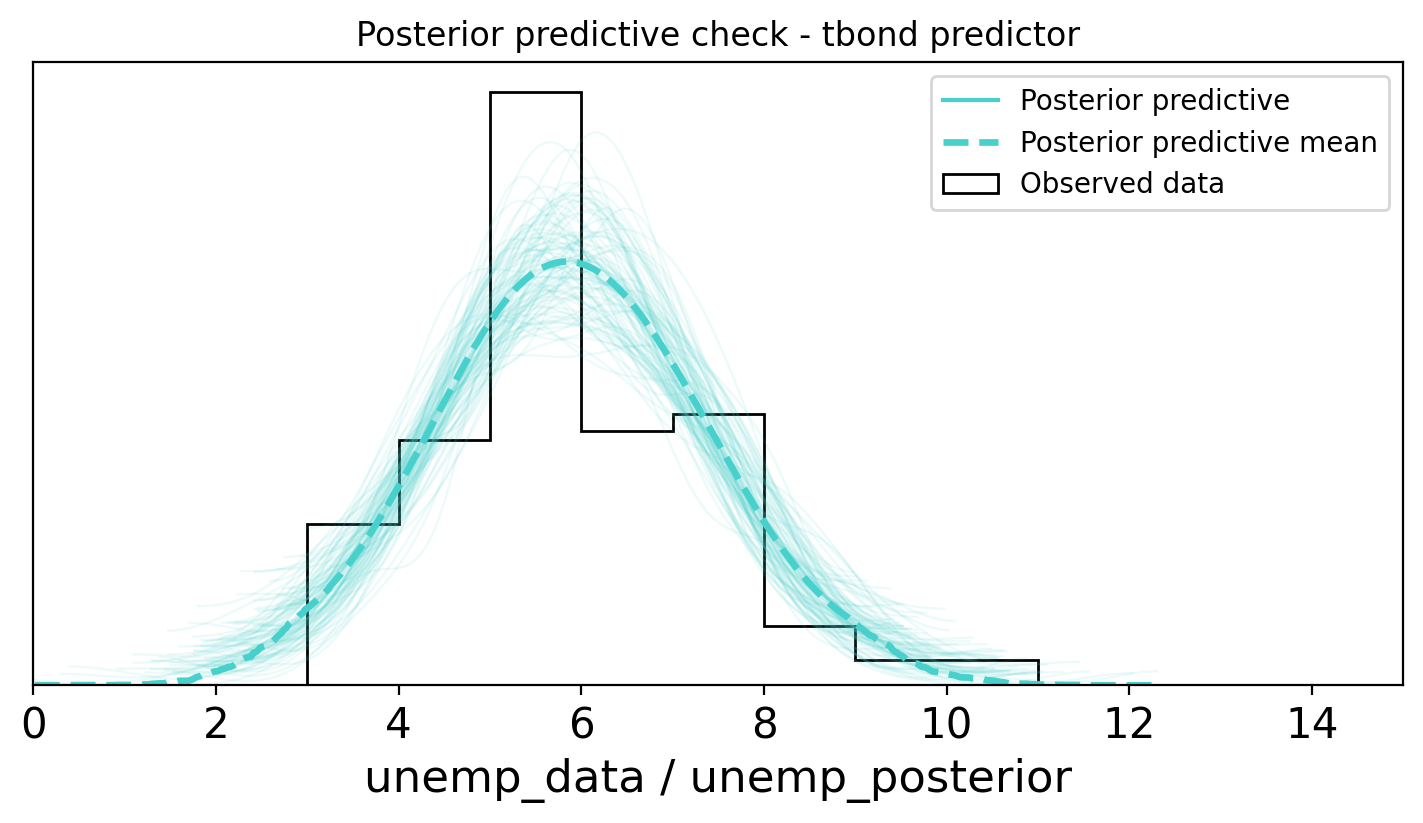

In [42]:
ax = az.plot_ppc(data = fit_id, 
                 alpha = 0.1, 
                 color = mid_highlight, 
                 figsize = (7, 4), 
                 data_pairs = {'unemp_data': 'unemp_posterior'},
                 num_pp_samples = 100,
                 observed = False)
ax.set_xlim((0, 15))
ax.hist(data.unemp, bins = np.linspace(0, 15, 16), histtype = 'step', 
        edgecolor = 'black', density = True, label = 'Observed data')
ax.set_title(r'Posterior predictive check - tbond predictor')
ax.legend()
plt.show()

### Model comparison

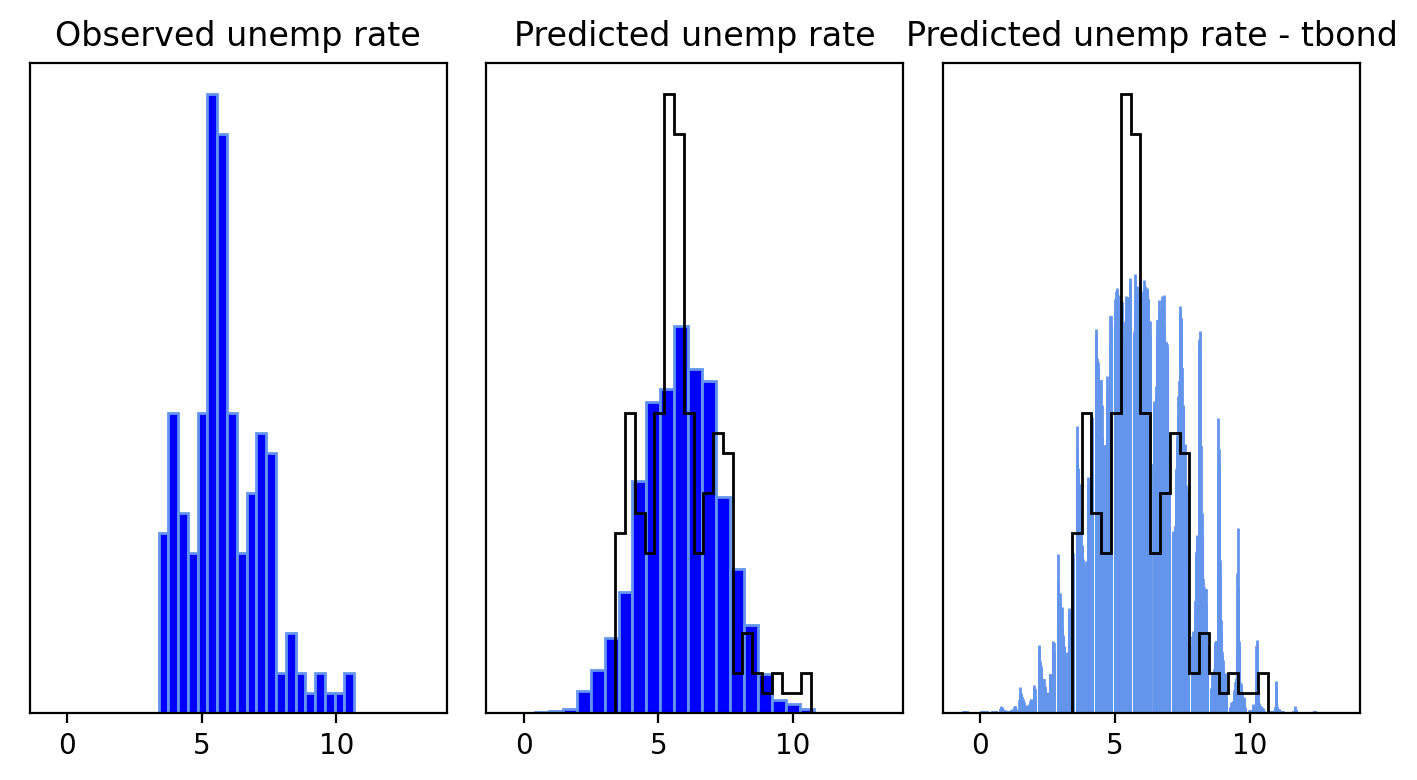

In [43]:
fig, axes = plt.subplots(1, 3, figsize = (7, 4), sharex = True, sharey = True)

ax = axes[0]
ax.hist(data.unemp, bins = 20, color = dark, edgecolor = dark_highlight, density = True)
ax.set_title('Observed unemp rate')
ax.set_yticks(())

ax2 = axes[1]
ax2.hist(unemp_posterior_pred, bins = 20, color = dark, edgecolor = dark_highlight, density = True)
ax2.hist(data.unemp, bins = 20, histtype = 'step', color = 'black', density = True)
ax2.set_title('Predicted unemp rate')
ax2.set_yticks(())

ax3 = axes[2]
color_arr = [mid]*len(data)
ax3.hist(unemp_posterior_pred_tbond, bins = 20, color = color_arr, edgecolor = dark_highlight, density = True)
ax3.hist(data.unemp, bins = 20, histtype = 'step', color = 'black', density = True)
ax3.set_title('Predicted unemp rate - tbond')
ax3.set_yticks(())

fig.tight_layout()

plt.show()

## Different predictor

The model incorporating tbond allowed for the better fit of the model to the actual data. 
In this section, I would like to examine the effect of ffrate (federal funds interest rate) on overall unemployment rate. 

### Centering of a variable

In [44]:
data['c_ffrate'] = (data.ffrate-data.ffrate.mean())/data.ffrate.mean()
data.head()

,quarter,date,unemp,cpi,ffrate,tbill,tbond,gbpusd,gdpjp,c_tbond,c_ffrate
0,1,1957,3.933333,27.776667,2.96,3.08,3.42,279.304688,10149.0,-0.433794,-0.502785
1,2,1957,4.100000,28.013334,3.00,3.29,3.65,279.023712,10904.0,-0.395716,-0.496066
2,3,1957,4.233333,28.263334,3.47,3.53,4.07,278.508789,11231.0,-0.326182,-0.417116
3,4,1957,4.933333,28.400000,2.98,3.04,3.18,280.579590,11075.0,-0.473528,-0.499426
4,5,1958,6.300000,28.736666,1.20,1.30,1.84,281.539795,10973.0,-0.695375,-0.798426


### Prior predictive checks

In [45]:
with open('macro_3_ppc.stan', 'r') as file:
    print(file.read())

data {
  int N;
  real ffrate[N];
}

generated quantities {
  real alpha = normal_rng(5, 1);
  real beta = lognormal_rng(0, 1);
  real sigma = exponential_rng(1);
  real unemp[N];
  for (i in 1:N) {
    unemp[N] = normal_rng(ffrate[N]*beta + alpha, sigma);
  }
}



In [46]:
macro_3_ppc_model = CmdStanModel(stan_file = 'macro_3_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: C:/Users/Karolina/DA_2021/8MINIP~1/macro_3_ppc.exe


In [47]:
R = 1000
data_sim = dict(N = len(data), ffrate = data.c_ffrate.values)

sim = macro_3_ppc_model.sample(data = data_sim,
                               iter_sampling = R,
                               iter_warmup = 0,
                               chains = 1,
                               fixed_param = True,
                               seed = 11062021)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [48]:
alpha_sim = sim.stan_variable('alpha')
beta_sim = sim.stan_variable('beta')

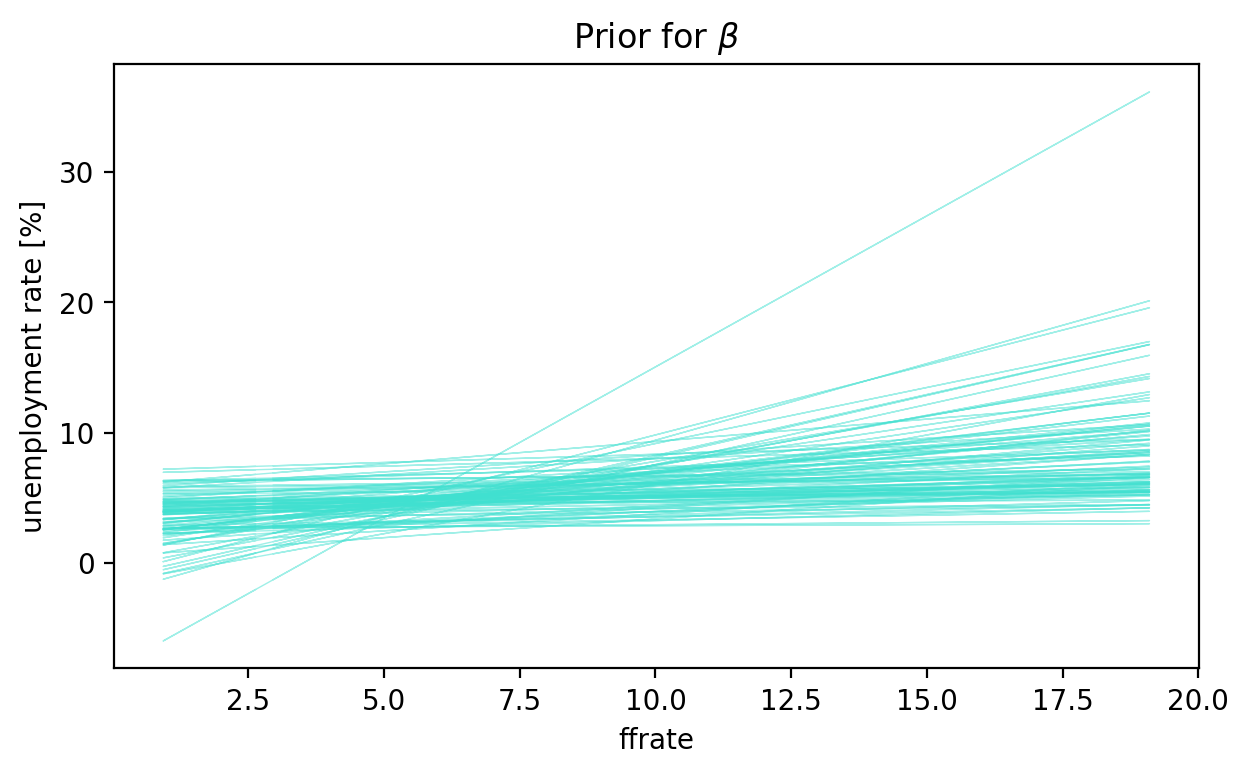

In [49]:
fig, axes = plt.subplots(1, 1, figsize = (7, 4))
for i in range(100):
    axes.plot(data.ffrate, alpha_sim[i] + beta_sim[i]*data.c_ffrate, color = mid, alpha = 0.5, linewidth = 0.5)
axes.set_xlabel('ffrate')
axes.set_ylabel('unemployment rate [%]')
axes.set_title(r'Prior for $\beta$')
plt.show()

### Posterior inference

In [50]:
with open('macro_3_fit.stan', 'r') as file:
    print(file.read())

data {
  int N;
  vector[N] ffrate;
  real unemp_data[N];
}

parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}

transformed parameters {
  vector[N] mu = ffrate*beta + alpha;
}

model {
  alpha ~ normal(5, 1);
  beta ~ lognormal(0, 1);
  sigma ~ exponential(1);
  unemp_data ~ normal(mu, sigma);
}

generated quantities {
  vector[N] log_lik;
  real unemp_posterior[N];
  for (i in 1:N) {
    log_lik[i] = normal_lpdf(unemp_data[i] | mu[i], sigma);
    unemp_posterior[i] = normal_rng(mu[i], sigma);
  }
}



In [51]:
macro_3_fit_model = CmdStanModel(stan_file = 'macro_3_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: C:/Users/Karolina/DA_2021/8MINIP~1/macro_3_fit.exe


In [52]:
data_fit = dict(N = len(data),
                ffrate = data.ffrate.values,
                unemp_data = data.unemp.values)

macro_3_fit = macro_3_fit_model.sample(data = data_fit,
                                       seed = 11062021)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2


In [53]:
alpha_fit = macro_3_fit.stan_variable('alpha')
beta_fit = macro_3_fit.stan_variable('beta')
mu_fit = macro_3_fit.stan_variable('mu')
unemp_posterior_pred_ffrate = macro_3_fit.stan_variable('unemp_posterior')

In [54]:
az.summary(macro_3_fit, var_names = ['alpha', 'beta', 'sigma'], round_to = 2, kind = 'stats')

,mean,sd,hdi_3%,hdi_97%
alpha,5.18,0.19,4.83,5.54
beta,0.12,0.03,0.07,0.17
sigma,1.40,0.07,1.26,1.53


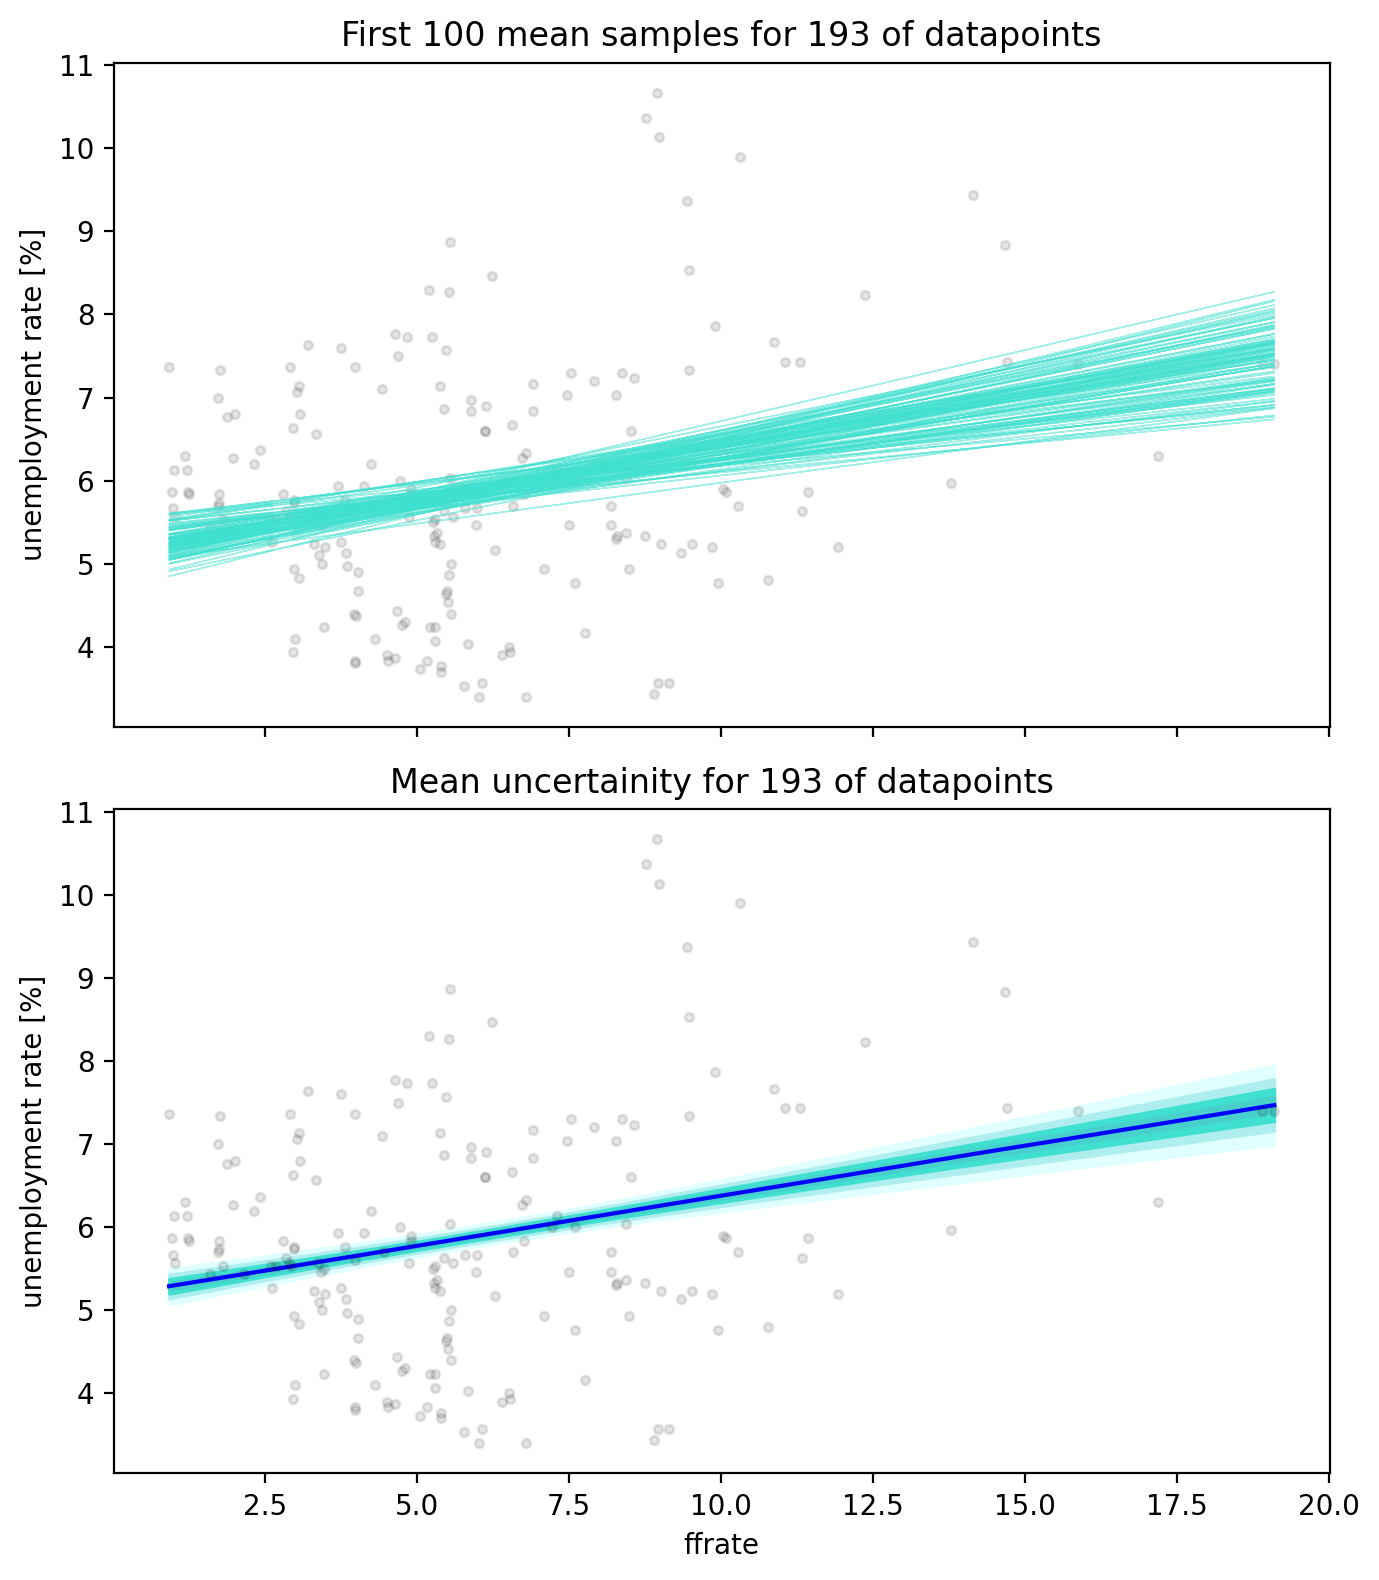

In [55]:
fig, axes = plt.subplots(2, 1, figsize = (7, 8), sharey = True, sharex = True)
ax0 = axes[0]
rng = 100
for i in range(rng):
    ax0.plot(data.ffrate,
             alpha_fit[i] + beta_fit[i]*data.ffrate,
             color = mid, alpha = 0.5, linewidth = 0.5)
ax0.scatter(data.ffrate, data.unemp, color = 'black', alpha = 0.1, s = 10)
ax0.set_ylabel('unemployment rate [%]')
ax0.set_title('First {0} mean samples for {1} of datapoints'.format(rng, len(data)))

ax1 = axes[1]
ax1 = ribbon_plot(data.ffrate.values, mu_fit, ax1, supress_warning = True)
ax1.scatter(data.ffrate, data.unemp, color = 'black', alpha = 0.1, s = 10)
ax1.set_xlabel('ffrate')
ax1.set_ylabel('unemployment rate [%]')

ax1.set_title('Mean uncertainity for {} of datapoints'.format(len(data)))
fig.tight_layout()
plt.show()

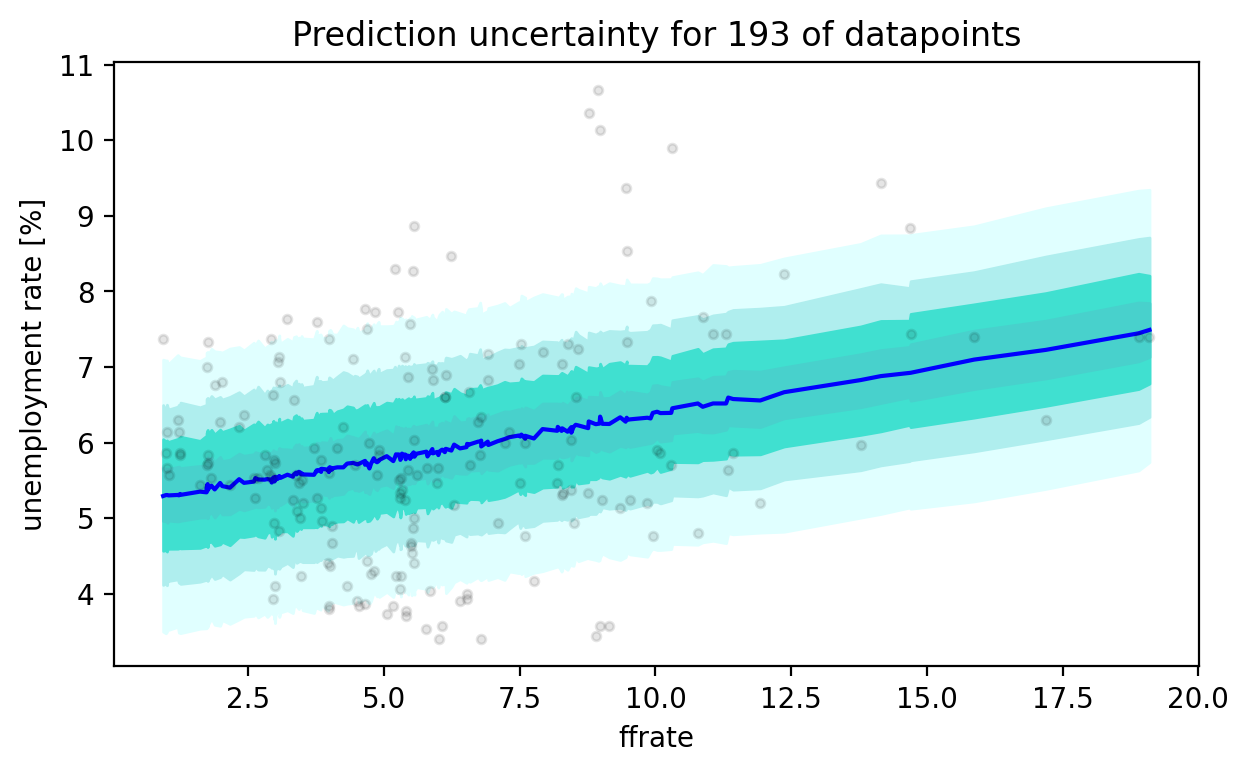

In [56]:
fig, axes = plt.subplots(1, 1, figsize = (7, 4))
axes = ribbon_plot(data.ffrate.values, unemp_posterior_pred_ffrate, axes, supress_warning = True)
axes.scatter(data.ffrate, data.unemp, color = 'black', alpha = 0.1, s = 10)
axes.set_xlabel('ffrate')
axes.set_ylabel('unemployment rate [%]')
axes.set_title('Prediction uncertainty for {} of datapoints'.format(len(data)))
plt.show()

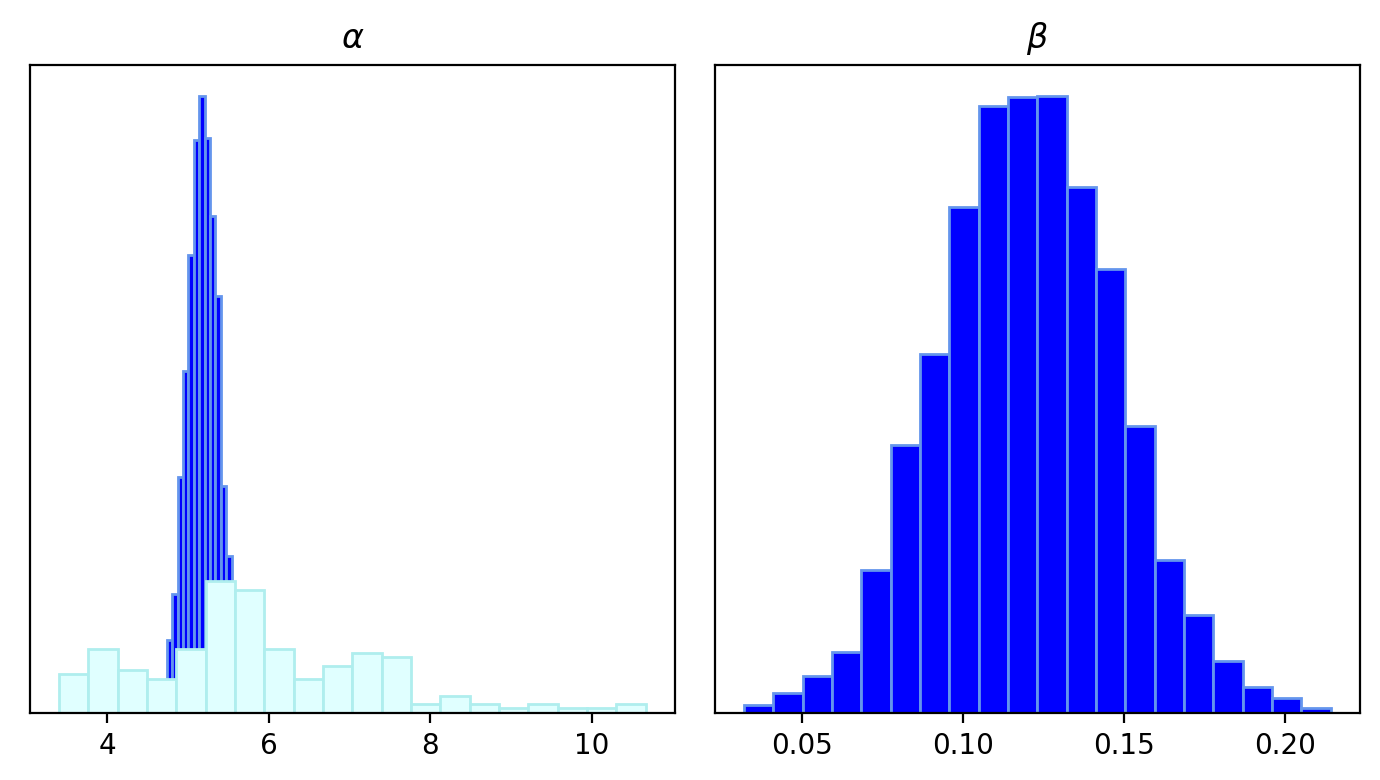

In [57]:
fig, axes = plt.subplots(1, 2, figsize = (7, 4))
ax = axes[0]
ax.hist(alpha_fit, bins = 20, color = dark, edgecolor = dark_highlight, density = True)
ax.hist(data.unemp, bins = 20, color = light, edgecolor = light_highlight, density = True)
ax.set_title(r'$\alpha$')
ax.set_yticks(())

ax2 = axes[1]
ax2.hist(beta_fit, bins = 20, color = dark, edgecolor = dark_highlight, density = True)
ax2.set_title(r'$\beta$')
ax2.set_yticks(())

fig.tight_layout()
plt.show()

### Posterior predictive check

In [58]:
fit_id2 = az.from_cmdstanpy(posterior = macro_3_fit,
                                       log_likelihood = 'log_lik',
                                       posterior_predictive = 'unemp_posterior',
                                       observed_data = {'unemp_data': data['unemp']} )

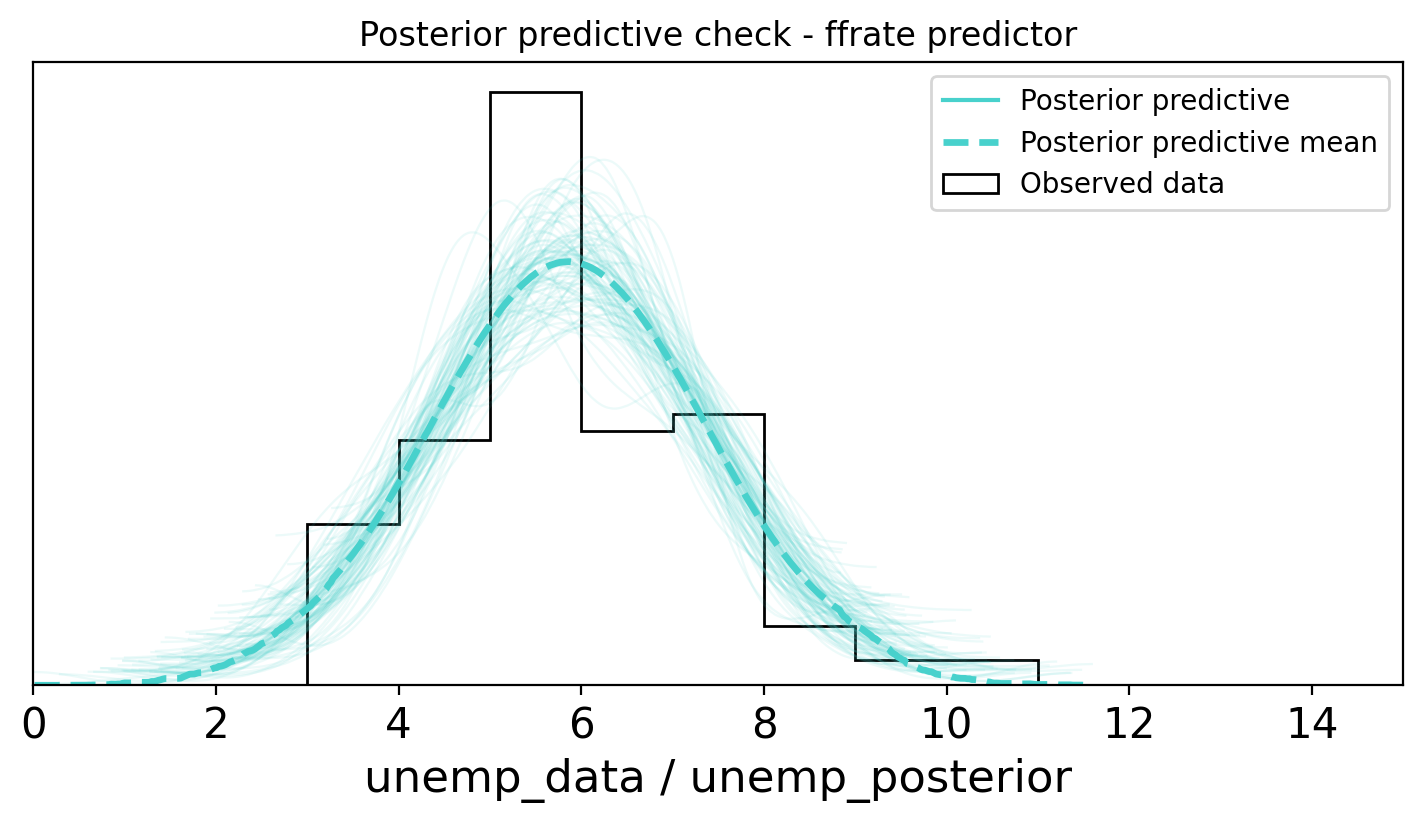

In [59]:
ax = az.plot_ppc(data = fit_id2, 
                 alpha = 0.1, 
                 color = mid_highlight, 
                 figsize = (7, 4), 
                 data_pairs = {'unemp_data': 'unemp_posterior'},
                 num_pp_samples = 100,
                 observed = False)
ax.set_xlim((0, 15))
ax.hist(data.unemp, bins = np.linspace(0, 15, 16), histtype = 'step', 
        edgecolor = 'black', density = True, label = 'Observed data')
ax.set_title(r'Posterior predictive check - ffrate predictor')
ax.legend()
plt.show()

### Model comparison

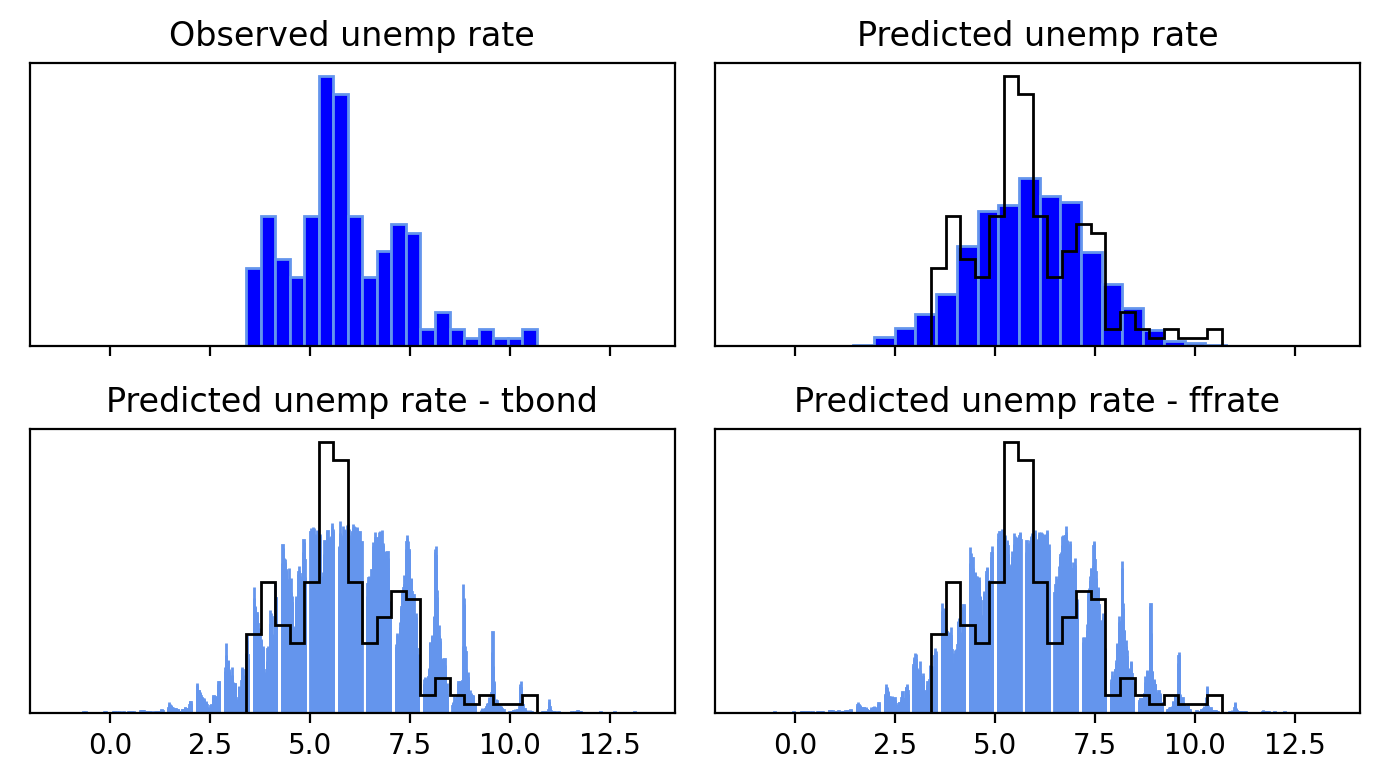

In [60]:
fig, axes = plt.subplots(2, 2, figsize = (7, 4), sharex = True, sharey = True)

ax = axes[0, 0]
ax.hist(data.unemp, bins = 20, color = dark, edgecolor = dark_highlight, density = True)
ax.set_title('Observed unemp rate')
ax.set_yticks(())

ax2 = axes[0, 1]
ax2.hist(unemp_posterior_pred, bins = 20, color = dark, edgecolor = dark_highlight, density = True)
ax2.hist(data.unemp, bins = 20, histtype = 'step', color = 'black', density = True)
ax2.set_title('Predicted unemp rate')
ax2.set_yticks(())

ax3 = axes[1, 0]
color_arr = [mid]*len(data)
ax3.hist(unemp_posterior_pred_tbond, bins = 20, color = color_arr, edgecolor = dark_highlight, density = True)
ax3.hist(data.unemp, bins = 20, histtype = 'step', color = 'black', density = True)
ax3.set_title('Predicted unemp rate - tbond')
ax3.set_yticks(())

ax4 = axes[1, 1]
color_arr = [mid]*len(data)
ax4.hist(unemp_posterior_pred_ffrate, bins = 20, color = color_arr, edgecolor = dark_highlight, density = True)
ax4.hist(data.unemp, bins = 20, histtype = 'step', color = 'black', density = True)
ax4.set_title('Predicted unemp rate - ffrate')
ax4.set_yticks(())

fig.tight_layout()

plt.show()

In [61]:
model_compare = az.compare(dataset_dict = {'Linear model - tbond predictor': fit_id, 
                                           'Linear model - ffrate predictor': fit_id2})
model_compare

C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Linear model - tbond predictor,0,-334.108816,2.851477,0.00000,1.0,10.024700,0.000000,False,log
Linear model - ffrate predictor,1,-339.742306,2.757373,5.63349,0.0,10.412336,1.357701,False,log


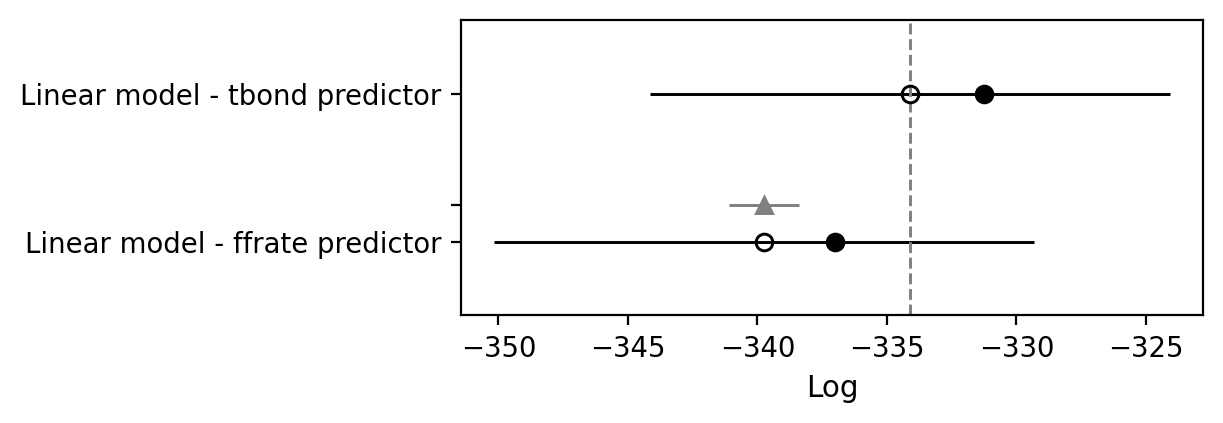

In [62]:
az.plot_compare(model_compare)
plt.show()